<a href="https://colab.research.google.com/github/jtao/AdvancedML/blob/main/Gaussian_Process_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Gaussian Process Regression


In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Kernels

Suppose we are given data with $x_i$ being the inputs and $y_i$ being the targets, $$(x_1,y_1), \ldots, (x_n,y_n)\in \mathcal{X}\times \mathcal{Y}$$
In learning, we want to get a model that can be able to generalize to unseen data points, meaning that we want to choose $y$ such that $(x,y)$ is in some sense similar to the training data. A similarity measure is required,
$$k:\mathcal{X}\times\mathcal{X}\rightarrow \mathbb{R}, (x, x') \mapsto k(x, x')$$
satisfying, for all $x, x'\in \mathcal{X}$,
$$k(x, x') = <\Phi(x), \Phi(x')>$$
where $\Phi$ maps into some feature space $\mathcal{H}$. The similarity measure $k(\cdot)$ is called *kernel* and $\Phi$ is called its *feature map*.

Some common choices of kernels:

*   Radial-basis function (RBF) kernel: $$k(x_i, x_j) = \exp\left(-\frac{d(x_i, x_j)^2}{2l^2}\right)$$
*   Matern kernel: $$k(x_i, x_j) = \frac{1}{\Gamma(\nu)2^{\nu - 1}}\left(\frac{\sqrt{2\nu}}{l}d(x_i, x_j)\right)^{\nu}K_{\nu}\left(\frac{\sqrt{2\nu}}{l}d(x_i, x_j)\right)$$
*   Absolute exponential kernel: (Matern kernel with $\nu = 1/2$) $$k(x_i, x_j) = \exp{\left(-\frac{d(x_i,x_j)}{l}\right)}$$
*   Rational quadratic kernel: $$k(x_i, x_j) = \left(1 + \frac{d(x_i, x_j)^2}{2\alpha l^2}\right)^{-\alpha}$$

## Gaussian Process Regression

**Gausian processes** are a supervised learning method designed to solve regression and probabilistic classification problems.

The advantages of Gaussian processes are:
* The prediction interpolates the observations (at least for regular kernels).
* The prediction is probabilistic (Gaussian) so that one can compute empirical confidence intervals and decide based on those if one should refit (online fitting, adaptive fitting) the prediction in some region of interest.
* Versatile: different kernels can be specified. Common kernels are provided, but it is also possible to specify custom kernels.

The disadvantages of Gaussian processes include:

* They are not sparse, i.e., they use the whole samples/features information to perform the prediction.
* They lose efficiency in high dimensional spaces – namely when the number of features exceeds a few dozens.

Implementation of Gaussian processes for regression purposes gives the Gaussian process regression (GPR). The prior of the GP needs to be specified. The prior mean is assumed to be constant. The prior covariance is specified through a kernel object.

The Bayesian approach infers a probability distribution over all possible values. Assume the linear function as following,
$$\mathbf{y} = \mathbf{w}\mathbf{x} + \boldsymbol{\epsilon}$$

The Bayesian approach specifies a prior distribution for $p(\mathbf{w})$ on the parameter $\mathbf{w}$ and relocating probabilities based on the observed data using Bayes' Rule:
$$p(\mathbf{w}|\mathbf{y}, \mathbf{x}) = \frac{p(\mathbf{y}|\mathbf{x},\mathbf{w})p(\mathbf{w})}{p(\mathbf{y}|\mathbf{x})}$$

To get the predictions at unseen points of interest $mathbf{x}^*$, the predictive distribution can be calculated by weighting all possible predictions by the posterior distribution
$$p(f^*|\mathbf{x}^*, \mathbf{y},\mathbf{x}) = \int_{\mathbf{w}}p(f^*|x^*, w)p(w|y, x)$$

In GPR, we first assume a Gaussian process prior through the mean and covariance function, like an infinite-dimensional multivariate Gaussian distribution.
$$f(x)\sim GP(m(x), k(x, x'))$$
$$y\sim GP(m(x), k(x, x') + \delta_{ij}\sigma^2), \text{ where }y = f(x) + \epsilon, \epsilon \sim N(0, \sigma^2)$$
From the Gaussian process prior, the collection of training and test data points are joint multivariate Gaussian distributed, so the joint distribution can be written as
$$\left[\begin{array}{c}
y\\
f^*
\end{array}\right]\sim \mathcal{N}\left(\boldsymbol{\mu}^*, \boldsymbol{\Sigma}^*\right)$$
where
$$\boldsymbol{\mu}^* = [\boldsymbol{\mu}, \mu^*], \boldsymbol{\Sigma^*} = \left[\begin{array}{cc}
K(X, X)+\sigma^2 I & K(X, x^*)\\
K(x^*, X) & K(x^*, x^*)\end{array}\right]$$

### Example

Random generate data from a uniform distribution.

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel as C

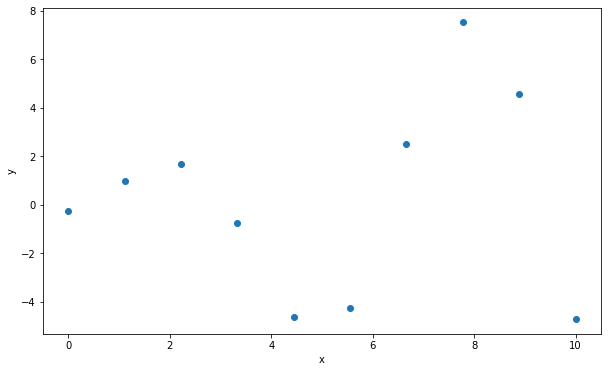

In [ ]:
rng = np.random.RandomState(1)
X = np.linspace(0, 10, 10)
y = X * np.sin(X)
dy = 0.1 + 0.5 * np.random.random(y.shape)
noise = np.random.normal(0, dy)
y += noise
# GaussFeats = GaussianFeatures(10).fit_transform(x.reshape(-1, 1))

plt.figure(figsize = (10, 6))
# plt.subplot(1,2,1)
plt.scatter(X, y)
plt.xlabel('x')
plt.ylabel('y')

# plt.subplot(1,2,2)
# for i in range(10):
#     plt.plot(x, GaussFeats[:, i], '--', color = 'C'+ str(i),  linewidth = 0.5)

# plt.xlabel('x')
# plt.ylabel('Gaussian Features')

plt.show()

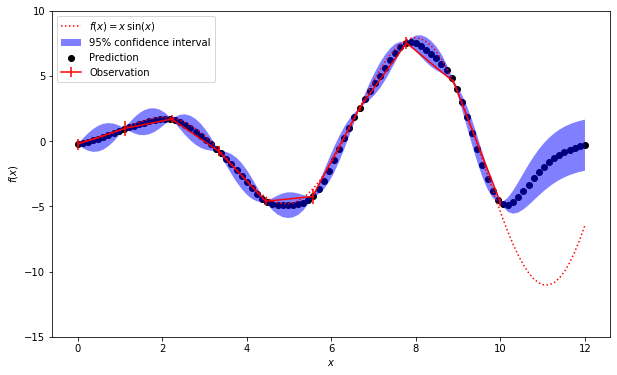

In [ ]:
x = np.linspace(0, 12, 100)

# Instantiate a Gaussian Process model
kernel = Matern(nu = 2.5)
gp = GaussianProcessRegressor(kernel = kernel, n_restarts_optimizer = 9)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X.reshape(-1, 1), y)

# Make the prediction on the testing dataset (ask for MSE as well)
y_pred, sigma = gp.predict(x.reshape(-1, 1), return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure(figsize=(10,6))
plt.plot(x, x * np.sin(x), 'r:', label=r'$f(x) = x\,\sin(x)$')
plt.scatter(x, y_pred, color = 'black', label='Prediction')
plt.errorbar(X, y, dy, label = 'Observation', color = 'red')
plt.fill(np.concatenate([x.reshape(-1, 1), x.reshape(-1, 1)[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-15, 10)
plt.legend(loc='upper left')

plt.show()

### A real data example

The data relates to an inverse dynamics problem for a seven degrees-of-freedom SARCOS anthropomorphic robot arm. The task is to map from a 21-dimensional input space (7 joint positions, 7 joint velocities, 7 joint accelerations) to the corresponding 7 joint torques. Following previous work we present results for just one of the seven mappings, from the 21 input variables to the first of the seven torques. The training data is of size $44484 \times 28$ and the test data is of size $4449 \times 28$.
The first 21 columns are the input variables, and the 22nd column is used as the target variable.

In [ ]:
training_data = pd.read_csv('https://raw.githubusercontent.com/XiaomengYan/MachineLearning_dataset/main/sarcos_inv.csv')
test_data = pd.read_csv('https://raw.githubusercontent.com/XiaomengYan/MachineLearning_dataset/main/sarcos_inv_test.csv')

X_train = training_data.iloc[:100, 1:22]
y_train = training_data.iloc[:100, 22]
X_test = test_data.iloc[:, 1:22]
y_test = test_data.iloc[:, 22]

In [ ]:
# Instantiate a Gaussian Process model
kernel = Matern(nu = 2.5)
gp = GaussianProcessRegressor(kernel = kernel, n_restarts_optimizer = 9)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X_train, y_train)

# Make the prediction on the testing dataset (ask for MSE as well)
y_pred, sigma = gp.predict(X_test, return_std=True)

MSE_test = np.mean(np.power(y_pred - y_test, 2))
print("MSE for the test set by GPR: ", MSE_test)

# Linear & Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, LinearRegression

regr = LinearRegression()
regr.fit(X_train, y_train)
y_pred_lr = regr.predict(X_test)

MSE_test = np.mean(np.power(y_pred_lr - y_test, 2))
print("MSE for the test set by linear model: ", MSE_test)

ridge_regr = Ridge(alpha = 2.0)
ridge_regr.fit(X_train,y_train)
y_pred_rg = ridge_regr.predict(X_test)

MSE_test = np.mean(np.power(y_pred_rg - y_test, 2))
print("MSE for the test set by Ridge model: ", MSE_test)

MSE for the test set by GPR:  362.69497537392914
MSE for the test set by linear model:  711519.7547611272
MSE for the test set by Ridge model:  246.41148282513618


## Reference
* [Notes for kernel ridge regression by Max Welling](https://www.ics.uci.edu/~welling/classnotes/papers_class/Kernel-Ridge.pdf)

## Hands-on exercises
### Classification

Please try to implement the SVM for classification of MNIST hand written digits dataset. Remember that different hyperparameters can have affect the results.

1. Prepare data: Load the MNIST dataset using `load_digits` from `sklearn.datasets`
2. Prepare the tool: load `svm` from `sklearn`
3. Split the data into training set and test set: use 70% for training and the remaining for testing, get help from `train_test_split` from `sklearn.model_selection`
4. Select the evaluation metric to evaluate the classification result
5. Try SVM with different settings and save the accuracy score in a dictionary with key being `kernel name_C`
 * $C = [0.001, 0.1, 0.5, 1, 10, 100]$ (Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive. The penalty is a squared l2 penalty.)
 * kernel = \{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’\} (Specifies the kernel type to be used in the algorithm.)
 6. Visualize the first 4 results in the test set using polynomial kernel with $C = 0.1$.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm

# loading data
from sklearn.datasets import load_digits

data = load_digits()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=17              #test_size controls the proportion of test data in the whole data
)
n_samples = len(data.images)
print(n_samples)

1797


In [ ]:
C_list = np.array([0.001, 0.1, 0.5, 1, 10, 100])
kernel_list = ['linear', 'poly', 'rbf', 'sigmoid']

accuracy_score_dict = dict()
for cc in C_list:
    for kern in kernel_list:
        clf_svm = svm.SVC(C = cc, kernel = kern)
        clf_svm.fit(X_train, y_train)
        svm_pred = clf_svm.predict(X_test)
        accuracy_score_dict[kern + '_' + str(cc)] = accuracy_score(y_test,svm_pred)

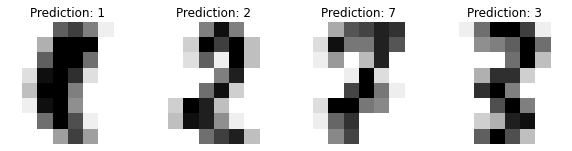

In [ ]:
clf_svm = svm.SVC(C = 0.1, kernel = 'poly')
clf_svm.fit(X_train, y_train)
svm_pred = clf_svm.predict(X_test)

_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, prediction in zip(axes, X_test, svm_pred):
    ax.set_axis_off()
    image = image.reshape(8, 8)
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title(f'Prediction: {prediction}')

### Regression